In [1]:
import numpy as np
import torch
from torch import nn, utils

import matplotlib.pyplot as plt
import os

In [2]:
# download data
url = 'https://gitlab.com/yuxuan.chen/'\
    'storage/-/raw/master/DL-2020/week2/'\
    'prediction-challenge-01-data.npz'
!wget -nc $url

with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)
print(test_x.shape, test_x.dtype)

File 'prediction-challenge-01-data.npz' already there; not retrieving.

(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


In [3]:
# split the data into train and valid set: 16000 vs. 4000
train_size = 18000
train_x, val_x = data_x[:train_size, ], data_x[train_size:, ]
train_y, val_y = data_y[:train_size, ], data_y[train_size:, ]

# transform all our numpy arrays into torch tensors
train_x, train_y, val_x, val_y, test_x = map(
    torch.tensor, (train_x, train_y, val_x, val_y, test_x))

In [4]:
# hyper-parameters
num_channels = [1, 16, 32]
num_classes = 10
num_epochs = 30
batch_size = 256
learning_rate = 0.002
weight_decay = 0.01

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# create datasets and dataloaders from our newly partitioned data
train_dataset = utils.data.TensorDataset(train_x,train_y)
train_loader = utils.data.DataLoader(dataset=train_dataset, 
                                     batch_size=batch_size, 
                                     shuffle=True, 
                                     pin_memory=True)

In [6]:
# build a CNN of 2 conv-layers
class ConvNet(nn.Module):
    def __init__(self, output_size, num_channels):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=num_channels[0], 
                      out_channels=num_channels[1], 
                      kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_channels[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=num_channels[1], 
                      out_channels=num_channels[2], 
                      kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(num_channels[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7 * 7 * num_channels[2], output_size)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

In [7]:
# set model, loss function and optimizer
model = ConvNet(output_size=num_classes, 
                num_channels=num_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

In [8]:
def accuracy(outputs, labels):
    assert outputs.size(0) == labels.size(0)

    _, pred = torch.max(outputs.data, 1)
    total = labels.size(0)
    hit = (pred == labels).sum()
            
    return 1.0 * hit / total

In [9]:
best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader: 
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_acc = accuracy(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print the result for the last batch of this epoch
    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(
            epoch + 1, num_epochs, loss.item()))
    print('Training Accuracy: {:.3f}%'.format(100 * train_acc))

    # validate after each epoch
    model.eval()
    with torch.no_grad():
        images, labels = val_x.to(device), val_y.to(device)

        outputs = model(images)
        val_acc = accuracy(outputs, labels)
        print('Validation Accuracy: {:.3f}%'.format(100 * val_acc))
        print('=' * 50)
        
        # save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if best_val_acc > 0.98:
                torch.save(model.state_dict(), './saved_model.ckpt')
            
print('Best Valid Accuracy: {:.3f}%'.format(100 * best_val_acc))

Epoch [1/30], Training Loss: 0.1054
Training Accuracy: 95.000%
Validation Accuracy: 96.550%
Epoch [2/30], Training Loss: 0.2417
Training Accuracy: 95.000%
Validation Accuracy: 97.550%
Epoch [3/30], Training Loss: 0.1067
Training Accuracy: 97.500%
Validation Accuracy: 98.300%
Epoch [4/30], Training Loss: 0.0447
Training Accuracy: 97.500%
Validation Accuracy: 98.400%
Epoch [5/30], Training Loss: 0.0333
Training Accuracy: 100.000%
Validation Accuracy: 96.950%
Epoch [6/30], Training Loss: 0.0608
Training Accuracy: 98.750%
Validation Accuracy: 98.050%
Epoch [7/30], Training Loss: 0.1152
Training Accuracy: 95.000%
Validation Accuracy: 98.000%
Epoch [8/30], Training Loss: 0.0945
Training Accuracy: 97.500%
Validation Accuracy: 98.000%
Epoch [9/30], Training Loss: 0.0297
Training Accuracy: 98.750%
Validation Accuracy: 98.550%
Epoch [10/30], Training Loss: 0.0682
Training Accuracy: 96.250%
Validation Accuracy: 98.150%
Epoch [11/30], Training Loss: 0.0234
Training Accuracy: 100.000%
Validation Ac

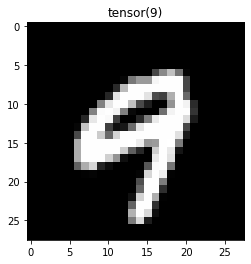

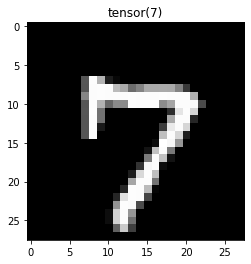

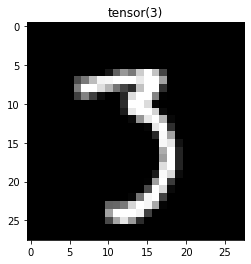

In [10]:
# load the saved model
saved_model = ConvNet(num_classes, num_channels).to(device)
saved_model.load_state_dict(torch.load('./saved_model.ckpt', 
                                       map_location=device))

# predict on test set with the saved model
saved_model.eval()
with torch.no_grad():
   test_pred = saved_model(test_x.to(device))
   _, test_pred = torch.max(test_pred.data, 1)

# show some answers
for i in range(3):
    plt.imshow(test_x[i].reshape(28, 28), cmap='gray')
    plt.title(test_pred[i])
    plt.show()